# Dependencies

In [ ]:
!pip install gym\[atari,accept-rom-license\]==0.21.0

# GPU Info

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Fri Apr 15 08:56:13 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 54.8 gigabytes of available RAM

You are using a high-RAM runtime!


# Imports

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import resize

import torch
import torch.nn as nn

import os, dill
import random, time
import gym

from collections import namedtuple, deque
from copy import deepcopy, copy
from datetime import datetime

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Wrapper class for Pong

[source](https://github.com/PacktPublishing/Deep-Reinforcement-Learning-Hands-On/blob/master/Chapter06/lib/wrappers.py)

In [ ]:
class FireResetEnv(gym.Wrapper):
    def __init__(self, env=None):
        super(FireResetEnv, self).__init__(env)
        assert env.unwrapped.get_action_meanings()[1] == 'FIRE'
        assert len(env.unwrapped.get_action_meanings()) >= 3

    def step(self, action):
        return self.env.step(action)

    def reset(self):
        self.env.reset()
        obs, _, done, _ = self.env.step(1)
        if done:
            self.env.reset()
        obs, _, done, _ = self.env.step(2)
        if done:
            self.env.reset()
        return obs

# Explore environment

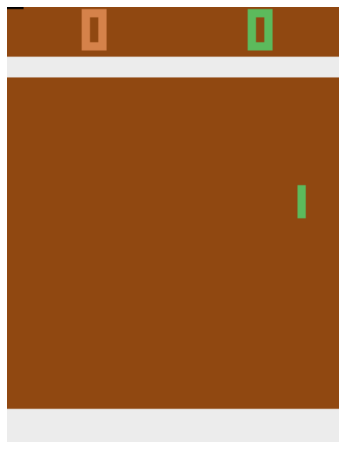

In [ ]:
env = gym.make("PongDeterministic-v4")
env = FireResetEnv(env)
state = env.reset()
plt.figure(figsize=(12,8))
plt.imshow(state)
plt.axis('off')
plt.show()

In [ ]:
print(f'Number of possible actions: {env.action_space.n}')

Number of possible actions: 6


In [ ]:
def play_one_episode():
    done = False
    s = env.reset()
    reward = 0
    while not done:
        s, r, done, _ = env.step(env.action_space.sample())
        reward += r

    return reward


# Preprocessing:

1. Convert to grayscale.
2. Ressize to 75 x 80

In [ ]:
# # convert to gray scale
# def convert_to_gray(img):
#     return np.dot(img, [0.2989, 0.5870, 0.1140])

[source](https://gist.github.com/karpathy/a4166c7fe253700972fcbc77e4ea32c5)

In [ ]:
def convert_to_gray_rescale(img):
    """ prepro 210x160x3 uint8 frame into 6000 (75x80) 1D float vector """
    img = img[35:185] # crop - remove 35px from start & 25px from end of image in x, to reduce redundant parts of image (i.e. after ball passes paddle)
    img = img[::2,::2,0] # downsample by factor of 2.
    img[img == 144] = 0 # erase background (background type 1)
    img[img == 109] = 0 # erase background (background type 2)
    img[img != 0] = 1 # everything else (paddles, ball) just set to 1. this makes the image grayscale effectively
    return img 

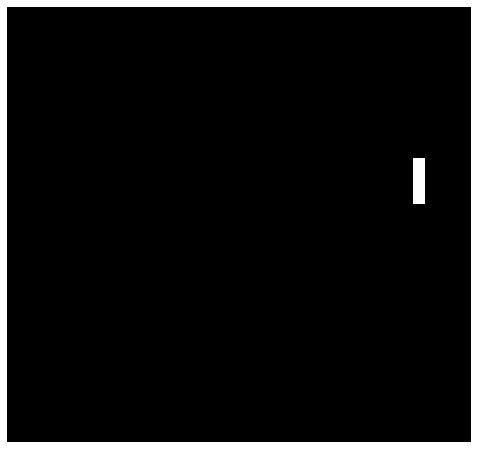

In [ ]:
state_g = convert_to_gray_rescale(state)
plt.figure(figsize=(12,8))
plt.imshow(state_g, cmap='gray')
plt.axis('off')
plt.show()

In [ ]:
def normalize(img):
    return img / 255

In [ ]:
# putting everything together
def preprocess(img):
    img_g = convert_to_gray_rescale(img)
    #img_t = resize(img_g, (84, 84))
    img_n = normalize(img_g)
    return img_n

# Replay Buffer Class


In [ ]:
class ReplayBuffer(object):
    def __init__(self, env, capacity, n_frames):
        self.env = env
        self.capacity = capacity
        self.n_frames = n_frames
        self.buffer = namedtuple('Buffer', field_names=['state', 'action', 'reward', 'done','next_state'])
        self.memory = deque(maxlen=capacity)
        
    def push(self, state, action, reward, done, next_state):
        # convert (state, action, next_state, reward, done)
        self.memory.append(self.buffer(state, action, reward, done, next_state))
        
        
    def sample(self, batch_size):
        indices = np.random.choice(len(self.memory), batch_size, replace=False)
        batch = zip(*[self.memory[i] for i in indices])
        return batch
    
    def populate(self, length):
        # populate buffer
        state_frames = deque(maxlen=self.n_frames)
        next_state_frames = deque(maxlen=self.n_frames)
        zeros = np.zeros((75,80))


        while len(self.memory) < length:
            # init frames
            for i in range(self.n_frames):
                state_frames.append(zeros)
                next_state_frames.append(zeros)
            
            done = False
            s0 = self.env.reset()
            while not done:
                action = self.env.action_space.sample()
                s1, r, done, _ = self.env.step(action)

                # build input states
                s0_t = preprocess(s0) # (84, 84)
                state_frames.append(s0_t) # stack of 4 (84,84)
                s1_t = preprocess(s1) # (84, 84)
                next_state_frames.append(s1_t) # stack of 4 (84,84)

                # stack 4 frames in  tensor
                input_state = np.stack(state_frames)
                input_next_state = np.stack(next_state_frames)

                # update buffer
                self.push(input_state, action, r, done, input_next_state)
                s0 = s1

                if len(self.memory) >= length:
                    break
        
    def __len__(self):
        return len(self.memory)

# Vanilla Q-network class

In [ ]:
class QNetwork(nn.Module):
    def __init__(self,env, n_frames):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(n_frames, 32, kernel_size=8, stride=4), # input_shape: batch_size x 4 x 84 x 84 -> batch_size x 32 x 20 x 20
            #nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            #nn.BatchNorm2d(64),
            nn.ReLU(), 
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            #nn.BatchNorm2d(64),
            nn.ReLU(),
            )
        
        conv_out_shape = self._get_input_shape([4,75,80]) # replace (75,80) by your input shape


        self.fc = nn.Sequential(
            nn.Linear(conv_out_shape, 512),
            nn.ReLU(),
            nn.Linear(512, env.action_space.n)
        )
              
    def forward(self, x):
        # conv layer output
        features = self.conv(x)
        features = features.view(x.size(0), -1)

        q_values = self.fc(features)

        return q_values
        
    def _get_input_shape(self, shape):
        conv_out = self.conv(torch.zeros(1, *shape))
        return int(np.prod(conv_out.size()))
        

# Agent Class

In [ ]:
class Agent():
    def __init__(self, env, buffer, epsilon, epsilon_mid, epsilon_final, decay_mid, decay_final):
        self.env = env
        self.buffer = buffer
        self.epsilon = epsilon
        self.epsilon_start = epsilon
        self.epsilon_mid = epsilon_mid
        self.epsilon_final = epsilon_final
        self.decay_mid = decay_mid
        self.decay_final = decay_final
        self.state_frames = deque(maxlen=buffer.n_frames)
        self.next_state_frames = deque(maxlen=buffer.n_frames)
        self.reset_frames()
        
    def take_action(self, state):
        
        # build state frames
        state_frames = self.build_state_frames(state) # 4, 75, 80
        # which action to take ?
        action = self.get_action(state_frames)

        # take the action
        next_state, reward, done, _ = self.env.step(action)

        # build next state frames
        next_state_frames = self.build_next_state_frames(next_state)

        # push new buffer
        self.buffer.push(state_frames, action, reward, done, next_state_frames)
        
        return next_state, reward, done
        
    def get_action(self, state_frames):
        if random.random() < self.epsilon:
            action = self.env.action_space.sample()
        else:
            action = self.get_greedy_action(state_frames)
        return action
            
    def get_greedy_action(self, state_frames):
        with torch.no_grad():
            Q_network.eval()
            state_frames = np.expand_dims(state_frames, 0)
            state_frames = torch.FloatTensor(state_frames).to(device)
            index_action = torch.argmax(Q_network(state_frames).cpu()).item()
            Q_network.train()
        return index_action
    
    
    def learn(self, batch_size):
        # sample a batch
        batch = self.buffer.sample(batch_size)
        states, actions, rewards, dones, next_states = [i for i in batch]

        # transform batch to tensor then to device
        states_t = torch.FloatTensor(np.array(states)).to(device)
        actions_t = torch.LongTensor(np.array(actions)).to(device)
        rewards_t = torch.FloatTensor(np.array(rewards)).to(device)
        dones_t = torch.BoolTensor(np.array(dones)).to(device)
        next_states_t = torch.FloatTensor(np.array(next_states)).to(device)

        # update rule : q(s,a) = q(s,a) + (r + gamma * max_a'_q(s',a') - q(s,a))
        # y = r + gamma * max_a'_q(s',a')
        # get q_vals target
        next_q_values = Q_network(next_states_t).detach().max(1)[0]# batch size, 1
        next_q_values[dones_t] = 0 # zero the final states
        y = rewards_t + gamma * next_q_values
        y = y.unsqueeze(1)
    
        # q_values
        q_values = Q_network(states_t).gather(1, actions_t.reshape(-1, 1))
        
        # compute loss
        loss = criterion(q_values, y)
        
        # back prop
        optimizer.zero_grad()
        loss.backward()
        
        # # Trick: gradient clipping
        for param in Q_network.parameters():
            param.grad.data.clamp_(-1, 1)

        # gradient descent
        optimizer.step()
        
        return loss.item()
         
    def reset_frames(self):
        zeros = np.zeros((75,80))
        for i in range(self.buffer.n_frames):
            self.state_frames.append(zeros)
            self.next_state_frames.append(zeros)

    def build_state_frames(self, state):
        state_t = preprocess(state)
        self.state_frames.append(state_t)
        return np.stack(self.state_frames)

    def build_next_state_frames(self, next_state):
        next_state_t = preprocess(next_state)
        self.next_state_frames.append(next_state_t)
        return np.stack(self.next_state_frames)

    def update_epsilon(self):
        e = self.epsilon 

        if e > self.epsilon_mid:
            self.epsilon = max(self.epsilon_mid, e - self.decay_mid)
        else:
            self.epsilon = max(self.epsilon_final, e - self.decay_final)
 
    def reset_epsilon(self):
        self.epsilon = self.epsilon_start

In [ ]:
def copy_network(Q_network, Q_target):
    Q_target.load_state_dict(Q_network.state_dict())

### Standard Weight Initialization function

In [ ]:
def initialize_weights(m):
  if isinstance(m, nn.Conv2d):
      nn.init.kaiming_uniform_(m.weight.data,nonlinearity='relu')
      if m.bias is not None:
          nn.init.constant_(m.bias.data, 0)
#   elif isinstance(m, nn.BatchNorm2d):
#       nn.init.constant_(m.weight.data, 1)
#       nn.init.constant_(m.bias.data, 0)
  elif isinstance(m, nn.Linear):
      nn.init.kaiming_uniform_(m.weight.data)
      nn.init.constant_(m.bias.data, 0)

# Hyperparameters

In [ ]:
# Hyper params 
capacity = 40000
n_frames = 4
epsilon = 1
epsilon_mid = 0.1
epsilon_final = 0.02
initial_buffer_size = 10000
mid_exploration_frame = 1000000
final_exploration_frame = 2400000

decay_mid =  (epsilon - epsilon_mid) / mid_exploration_frame

decay_final = (epsilon_mid - epsilon_final) / (final_exploration_frame - mid_exploration_frame)


lr = 1e-4 #25e-5 # ok for pong
batch_size = 32

max_episodes = 5000
rewards_target = 19
window = 100
network_update_frequency = 4
#network_sync_frequency = 1000
network_epsilon_update_frequency = 1
gamma = 0.99


# Instantiate and populate buffer

In [ ]:
buffer = ReplayBuffer(env, capacity, n_frames)
t0 = datetime.now()
buffer.populate(initial_buffer_size)
dt = datetime.now() - t0

print("It took :", dt, "to populate buffer of size:", len(buffer))
agent = Agent(env, buffer, epsilon, epsilon_mid, epsilon_final, decay_mid, decay_final)

It took : 0:00:08.377611 to populate buffer of size: 10000


# Save / Load functions

In [ ]:
drive_path = "/content/drive/MyDrive/PongDeterministic-v4-DQN"

if not os.path.exists(drive_path):
    os.mkdir(drive_path)
data_names = ['models', 'mean_rewards', 'best_score', 'losses']
def save_data(episode, reward):

    print("saving to drive")

    for data in data_names:
        data_path = os.path.join(drive_path, data)
        if not os.path.exists(data_path):
            os.mkdir(data_path)

        if data == 'models':

            data_file_name = './pong_ep_{}_score_{}.pth'.format(episode, reward)
            data_file_path = os.path.join(data_path, data_file_name)

            torch.save(Q_network, data_file_path)
            print('model saved')        

        else:
            print("Saving " + data )
            data_file_name = data + f"_{episode}_{reward}.pkl"
            data_file_path = os.path.join(data_path, data_file_name)

            with open(data_file_path, 'wb') as f:
                if data == 'mean_rewards':
                    dill.dump(mean_episode_rewards, f)
                elif data == 'best_score':
                    dill.dump(best_score, f)
                elif data == 'losses':
                    dill.dump(episodes_loss, f)





In [ ]:
# 10652 _ 1873
def load_data(episode, reward):

    print("loading from drive")

    for data in data_names:
        data_path = os.path.join(drive_path, data)

        if data == 'models':
            data_file_name = f"pong_ep_{episode}_score_{reward}.pth"
            data_file_path = os.path.join(data_path, data_file_name)

            Q_network = torch.load(data_file_path, map_location=device)
            Q_target = torch.load(data_file_path, map_location=device)
            print("Models Loaded")
            print(Q_network)
        
        else:
            print("Loading " + data)
            data_file_name = data + f"_{episode}_{reward}.pkl"
            data_file_path = os.path.join(data_path, data_file_name)
            with open(data_file_path, 'rb') as f:
                if data == 'mean_rewards':
                    mean_episode_rewards = dill.load(f)
                    print("Rewards loaded, length of rewards:", len(mean_episode_rewards))
                elif data == 'best_score':
                    best_score = dill.load(f)
                    print("best score loaded:", best_score)
                elif data == 'losses':
                    episodes_loss = dill.load(f)
                    print("episodes_loss loaded, length of losses:", len(episodes_loss))

    return Q_network, Q_target, mean_episode_rewards, best_score, episodes_loss


    


# Instantiate model

In [ ]:
Q_network = QNetwork(env, n_frames)
Q_network.apply(initialize_weights)
Q_network.to(device)

QNetwork(
  (conv): Sequential(
    (0): Conv2d(4, 32, kernel_size=(8, 8), stride=(4, 4))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (5): ReLU()
  )
  (fc): Sequential(
    (0): Linear(in_features=1920, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=6, bias=True)
  )
)

In [ ]:
!ls /content/drive/MyDrive/PongDeterministic-v4-DDQN/models

pong_ep_1000_score_-1697.pth  pong_ep_1587_score_-1223.pth
pong_ep_1023_score_-1652.pth  pong_ep_1600_score_-1135.pth
pong_ep_1041_score_-1570.pth  pong_ep_629_score_-1898.pth
pong_ep_1053_score_-1477.pth  pong_ep_736_score_-1818.pth
pong_ep_1076_score_-1387.pth  pong_ep_964_score_-1737.pth
pong_ep_1120_score_-1305.pth


In [ ]:
# In case loading model
# Q_network, _ , mean_episode_rewards, best_score, episodes_loss = load_data(1600,-1135)
# Q_network.to(device)


loading from drive
Models Loaded
QNetwork(
  (conv): Sequential(
    (0): Conv2d(4, 32, kernel_size=(8, 8), stride=(4, 4))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (5): ReLU()
  )
  (fc): Sequential(
    (0): Linear(in_features=1920, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=6, bias=True)
  )
)
Loading mean_rewards
Rewards loaded, length of rewards: 1601
Loading best_score
best score loaded: -11.35
Loading losses
episodes_loss loaded, length of losses: 1601


QNetwork(
  (conv): Sequential(
    (0): Conv2d(4, 32, kernel_size=(8, 8), stride=(4, 4))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (5): ReLU()
  )
  (fc): Sequential(
    (0): Linear(in_features=1920, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=6, bias=True)
  )
)

# Training

In [ ]:
optimizer = torch.optim.Adam(Q_network.parameters(), lr=lr)
#optimizer = torch.optim.RMSprop(Q_network.parameters(), lr=lr)
criterion = nn.MSELoss()

In [ ]:
# 10652 _ 1873
#Q_network, Q_target, mean_episode_rewards, best_score, episodes_loss = load_data(10652, 1873)

In [ ]:
# training loop
t0 = datetime.now()

steps = 0

training_rewards = []
training_loss = []
mean_episode_rewards = []
episodes_reward = []
episodes_loss = []

best_score = -21
save_score_target = -19

current_episode = len(mean_episode_rewards)
# steps = 2044480

# training_loss = episodes_loss
# episodes_reward = mean_episode_rewards
# save_score_target = best_score + 0.8

for i in range(max_episodes):
    
    done = False
    s0 = env.reset()
    ep_rewards = 0
    ep_losses = []
    agent.reset_frames()
    
    while not done:
        steps += 1
        
        # taking action
        s0, reward, done = agent.take_action(s0)
        ep_rewards += reward
        
        # learning
        if steps % network_update_frequency == 0:
            loss = agent.learn(batch_size)
            ep_losses.append(loss)
        
        # # syncing
        # if steps % network_sync_frequency == 0:
        #     copy_network(Q_network, Q_target)

        # update epsion
        if steps % network_epsilon_update_frequency == 0 and steps >= 50000:
            agent.update_epsilon()
        
    if done:    
        # updates after end of episode
        episodes_reward.append(ep_rewards)
        episodes_loss.append(np.mean(ep_losses))

        if len(episodes_reward) >= window:
            mean_rewards = np.mean(
                                episodes_reward[-window:])
            mean_episode_rewards.append(mean_rewards)

        else:
            mean_rewards = np.mean(
                                episodes_reward)
            mean_episode_rewards.append(mean_rewards)


        if mean_rewards > best_score:
            best_score = mean_rewards
            if mean_rewards > save_score_target:
                    save_score_target = mean_rewards + 0.8
                    save_data(i+current_episode, int(100*mean_rewards))
                    print(f'Model Saved. Total Steps: {steps}. New best score: {mean_rewards}')
                
        if i % 10 == 0:
            print("Episode {:d} Mean Rewards {:.2f} ".format(
                        i+current_episode, mean_rewards))
        if i % 100 ==0:
            print('Total steps so far:', steps)
            if agent.epsilon > agent.epsilon_final:
                print('Current epsilon:', agent.epsilon)
        
        if i % 1000 ==0 and i>0:
            print("Check point")
            save_data(i+current_episode, int(100*mean_rewards))


        if mean_rewards >= rewards_target:
            print(f"Environment Solved after {i} episodes and {steps} steps")
            break
        

            
        
        
dt = (datetime.now() - t0)
print('Script run in:', dt, 'seconds')



Episode 0 Mean Rewards -19.00 
Total steps so far: 979
Current epsilon: 1
Episode 10 Mean Rewards -20.45 
Episode 20 Mean Rewards -20.43 
Episode 30 Mean Rewards -20.45 
Episode 40 Mean Rewards -20.41 
Episode 50 Mean Rewards -20.49 
Episode 60 Mean Rewards -20.51 
Episode 70 Mean Rewards -20.48 
Episode 80 Mean Rewards -20.51 
Episode 90 Mean Rewards -20.53 
Episode 100 Mean Rewards -20.53 
Total steps so far: 90897
Current epsilon: 0.9631918000012119
Episode 110 Mean Rewards -20.50 
Episode 120 Mean Rewards -20.50 
Episode 130 Mean Rewards -20.49 
Episode 140 Mean Rewards -20.53 
Episode 150 Mean Rewards -20.51 
Episode 160 Mean Rewards -20.43 
Episode 170 Mean Rewards -20.43 
Episode 180 Mean Rewards -20.40 
Episode 190 Mean Rewards -20.41 
Episode 200 Mean Rewards -20.42 
Total steps so far: 183597
Current epsilon: 0.8797618000039586
Episode 210 Mean Rewards -20.42 
Episode 220 Mean Rewards -20.43 
Episode 230 Mean Rewards -20.38 
Episode 240 Mean Rewards -20.33 
Episode 250 Mean R

In [ ]:
print("steps:", steps)

steps: 9394934


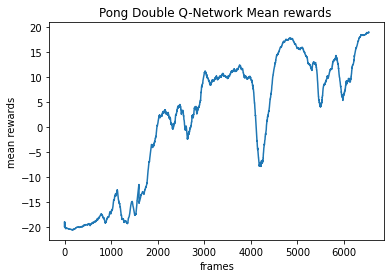

In [ ]:
plt.plot(mean_rewards)
#plt.legend()
plt.title("Pong Double Q-Network Mean rewards ")
plt.xlabel('frames')#, fontsize=18)
plt.ylabel('mean rewards')#, fontsize=16)
plt.show()
